<a href="https://colab.research.google.com/github/AliceAl/TimeSeries/blob/master/test_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Axes: >

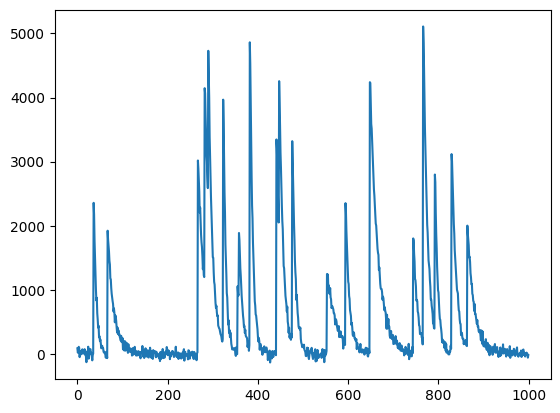

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Generate a time series
time = np.arange(0, 1000, 1)

# Create a base noise level
noise_level = np.random.normal(0, 50, size=time.size)

# Initialize the signal with base noise
signal = noise_level.copy()

# Add random spikes for rainfall events
for _ in range(20):  # 20 random spikes
    spike_time = np.random.choice(time)
    spike_magnitude = np.random.uniform(1000, 5000)
    signal[spike_time] += spike_magnitude

    # Add exponential decay after the spike to simulate the settling effect
    decay_rate = np.random.uniform(0.02, 0.1)
    for t in range(spike_time + 1, time.size):
        signal[t] += spike_magnitude * np.exp(-decay_rate * (t - spike_time))
        spike_magnitude *= np.exp(-decay_rate)

# Plot the synthetic turbidity signal
s = pd.Series(signal)
s.plot()

# Filtre moyenne

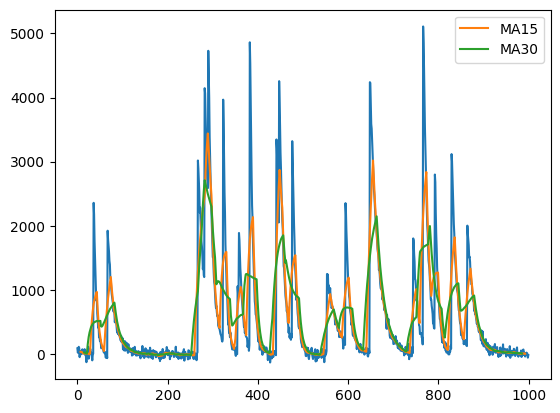

In [ ]:
mavg15 = s.rolling(15, center=True).mean()
mavg30 = s.rolling(30, center=True).mean()
ax = s.plot()
mavg15.plot(ax=ax, label='MA15')
mavg30.plot(ax=ax, label='MA30')
ax.legend()

# Filtre Gaussien

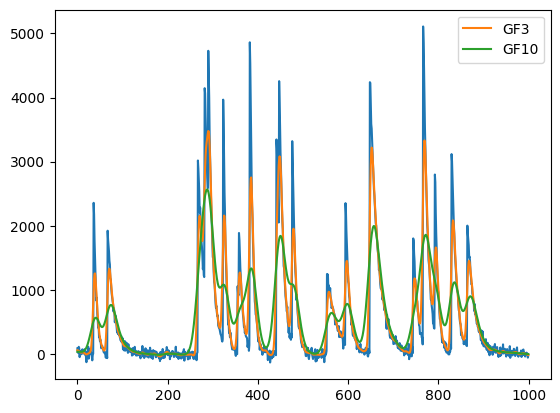

In [ ]:
from scipy.ndimage import gaussian_filter1d

gf3 = pd.Series(gaussian_filter1d(s, sigma=3))
gf10 = pd.Series(gaussian_filter1d(s, sigma=10))
ax = s.plot()
gf3.plot(ax=ax, label='GF3')
gf10.plot(ax=ax, label='GF10')
ax.legend()

# Filtre mediane

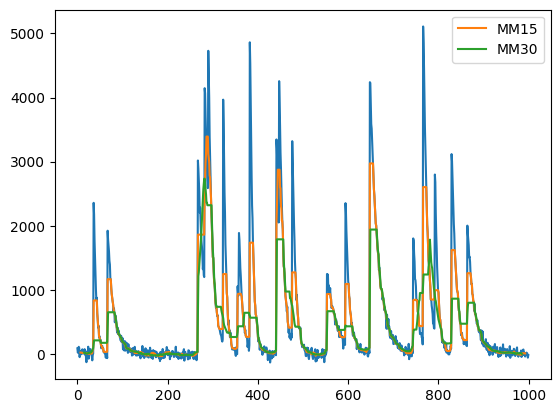

In [ ]:
mmed15 = s.rolling(15, center=True).median()
mmed30 = s.rolling(30, center=True).median()
ax = s.plot()
mmed15.plot(ax=ax, label='MM15')
mmed30.plot(ax=ax, label='MM30')
ax.legend()

# Wavelet denoising

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


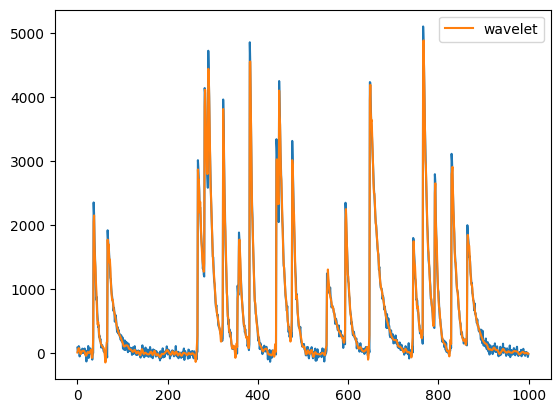

In [ ]:
import numpy as np
import pywt


def wavelet_denoising(signal: np.ndarray, wavelet: str = 'db4', level: int = None) -> np.ndarray:
    """
    Apply wavelet denoising on a 1D signal.

    Parameters
    ----------
    signal : np.ndarray
        The input signal to be denoised.
    wavelet : str, optional
        The type of wavelet to use, by default 'db4'.
    level : int, optional
        The decomposition level. If None, the function will calculate the maximum level possible.

    Returns
    -------
    np.ndarray
        The denoised signal.

    Notes
    -----
    This function utilizes the Discrete Wavelet Transform for signal decomposition,
    applies a universal threshold for noise reduction, and uses inverse DWT for reconstruction.
    """
    # Decompose to obtain the wavelet coefficients
    coeff = pywt.wavedec(signal, wavelet, mode='per', level=level)

    # Calculate the universal threshold
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply threshold to each coefficients array
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])

    # Reconstruct the signal using the inverse DWT
    return pywt.waverec(coeff, wavelet, mode='per')

#you can experiment with the wavelet type and level (or leave blank) but
# privilege wavelets with sharp transition to preserve edges, e.g., db4
denoised_signal = wavelet_denoising(signal, wavelet='db4', level=2)
s_wt = pd.Series(denoised_signal)
print(pywt.wavelist(kind='discrete'))
ax = s.plot()
s_wt.plot(ax=ax, label='wavelet')
ax.legend()

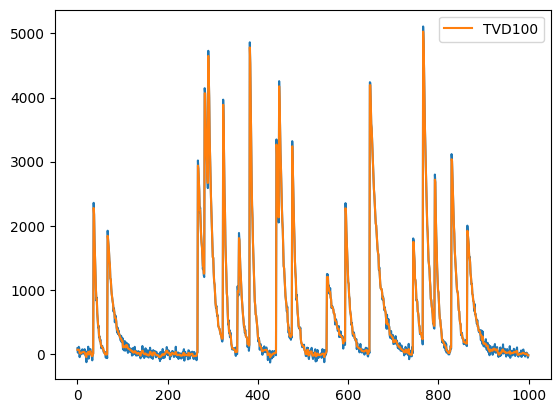

In [ ]:
from scipy.optimize import minimize


def tvd(signal: np.ndarray, alpha: float = 0.1) -> np.ndarray:
    """
    Apply Total Variation Denoising on a 1D signal.

    Parameters
    ----------
    signal : np.ndarray
        The input noisy signal.
    alpha : float, optional
        Regularization parameter controlling the trade-off between
        fidelity to the original signal and smoothness of the output,
        by default 0.1.

    Returns
    -------
    np.ndarray
        The denoised signal.
    """
    # Objective function: Sum of squared differences (fidelity) + TV norm
    def objective(x):
        return np.sum((x - signal) ** 2) + alpha * np.sum(np.abs(np.diff(x)))

    # Initial guess (the original signal)
    x0 = signal.copy()

    # Optimization constraints: None in this case
    # Optimization bounds: None, but could be set based on signal range

    # Perform optimization using L-BFGS-B algorithm
    res = minimize(objective, x0, method='L-BFGS-B')

    # The optimized result as the denoised signal
    return res.x

# Apply Total Variation Denoising
tvd100 = pd.Series(tvd(s, alpha=100))  # Adjust alpha as needed
ax = s.plot()
tvd100.plot(ax=ax, label='TVD100')
ax.legend()